In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats
import itertools
import logging
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler

from nf.flows import *
from nf.models import NormalizingFlowModel
import matplotlib.pyplot as plt

In [3]:
! ls ../data/data_calibsample

kaon2_+_down_2016_.csv	muon_+_down_2016_.csv	pion_+_down_2016_.csv
kaon2_+_up_2016_.csv	muon_+_up_2016_.csv	pion_+_up_2016_.csv
kaon2_-_down_2016_.csv	muon_-_down_2016_.csv	pion_-_down_2016_.csv
kaon2_-_up_2016_.csv	muon_-_up_2016_.csv	pion_-_up_2016_.csv
kaon_+_down_2016_.csv	pion2_+_down_2016_.csv	proton_+_down_2016_.csv
kaon_+_up_2016_.csv	pion2_+_up_2016_.csv	proton_+_up_2016_.csv
kaon_-_down_2016_.csv	pion2_-_down_2016_.csv	proton_-_down_2016_.csv
kaon_-_up_2016_.csv	pion2_-_up_2016_.csv	proton_-_up_2016_.csv


In [4]:
data_dir = '../data/data_calibsample'
particle = 'muon'
weight_filed = 'probe_sWeight'
features = ['Brunel_P', 'Brunel_ETA', 'nTracks_Brunel']
dlls = ['RichDLLp', 'RichDLLe', 'RichDLLmu', 'RichDLLk', 'RichDLLbt']
fields = [weight_filed] + features + dlls

In [5]:
data = pd.concat([
    pd.read_csv(os.path.join(data_dir, f), sep='\t')[fields]
    for f in os.listdir(data_dir) if particle in f
]).sample(frac=1)
data.head()

,probe_sWeight,Brunel_P,Brunel_ETA,nTracks_Brunel,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
137589,-0.369148,18870.50,3.02384,114,-28.56220,-2.53903,0.495203,-43.82630,-28.67160
299768,-0.390243,7277.48,2.15546,138,-1.42885,-19.36570,0.236547,-1.42885,-1.42885
67855,1.127120,15031.90,2.89652,78,-32.93730,-16.36750,-4.889190,-51.59940,-32.93730
430495,-0.081348,13842.70,3.40036,188,-31.21810,-11.28640,-1.917570,-33.42640,-31.21810
488745,-0.201794,22280.30,4.31347,129,-31.26330,-6.82312,-2.739510,-30.86870,-40.00220


In [6]:
data = data[data.RichDLLe > -998]
data = data[data.RichDLLp != 0.0]
data.shape

(1984209, 9)

In [8]:
X, Y, weights = data[features].values, data[dlls].values, data[weight_filed].values
train_size = data.shape[0] * 7 // 10

X_train, Y_train, w_train = X[: train_size], Y[: train_size], weights[: train_size]
X_val, Y_val, w_val = X[train_size :], Y[train_size :], weights[train_size :]
X_train.shape, X_val.shape

((1388946, 3), (595263, 3))

In [174]:
# scaler = StandardScaler()
scaler = scaler = QuantileTransformer(
    output_distribution="normal",
    n_quantiles=100000,
    subsample=int(1e10)
)
scaler.fit(Y_train)
Y_train_scaled = scaler.transform(Y_train)

In [175]:
# torch.cuda.set_device(2)
device = 'cuda'

In [176]:
dataset = TensorDataset(torch.from_numpy(Y_train_scaled.astype(np.float32)).to(device))
dataloader = DataLoader(dataset, batch_size=8192)
dim = Y.shape[1]

In [218]:
def bin_probs(arr, vals, bins):
    arr_bins = np.cumsum(arr.reshape(-1, 1) > bins, axis=1)[:, -1] - 1
    bin_range = np.arange(bins.shape[0] - 1)
    bin_vals = (arr_bins == bin_range.reshape(-1, 1)) * vals
    bin_vals = np.sum(bin_vals, axis=1) / (np.sum(bin_vals != 0.0, axis=1) + 0.0001)
    new_bins = (bins[:-1] + bins[1:]) / 2
    
    return new_bins, bin_vals

In [196]:
class NormalizingFlowModel(nn.Module):

    def __init__(self, dim, prior, flows):
        super().__init__()
        self.dim = dim
        self.prior = prior
        self.flows = nn.ModuleList(flows)

    def forward(self, x):
        m, _ = x.shape
        log_det = torch.zeros(m).to(x.device)
        for flow in self.flows:
            x, ld = flow.forward(x)
            log_det += ld
        z, prior_logprob = x, self.prior.log_prob(x.to('cpu')).to(x.device)
        return z, prior_logprob, log_det

    def backward(self, z):
        m, _ = z.shape
        log_det = torch.zeros(m).to(z.device)
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z)
            log_det += ld
        x = z
        return x, log_det

    def sample(self, n_samples):
        z = self.prior.sample((n_samples,self.dim))
        if z.dim() != 2: z = self.prior.sample((n_samples,))
        x, _ = self.backward(z)
        return x

In [197]:
class MAF(nn.Module):
    """
    Masked auto-regressive flow.

    [Papamakarios et al. 2018]
    """
    def __init__(self, dim, hidden_dim = 8, base_network=FCNN):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        self.initial_param = nn.Parameter(torch.Tensor(2))
        for i in range(1, dim):
            self.layers += [base_network(i, 2, hidden_dim)]
        self.reset_parameters()

    def reset_parameters(self):
        init.uniform_(self.initial_param, -math.sqrt(0.5), math.sqrt(0.5))

    def forward(self, x):
        z = torch.zeros_like(x)
        log_det = torch.zeros(z.shape[0]).to(x.device)
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            z[:, i] = (x[:, i] - mu) / torch.exp(alpha)
            log_det -= alpha
        return z.flip(dims=(1,)), log_det

    def backward(self, z):
        x = torch.zeros_like(z)
        log_det = torch.zeros(z.shape[0]).to(z.device)
        z = z.flip(dims=(1,))
        for i in range(self.dim):
            if i == 0:
                mu, alpha = self.initial_param[0], self.initial_param[1]
            else:
                out = self.layers[i - 1](x[:, :i])
                mu, alpha = out[:, 0], out[:, 1]
            x[:, i] = mu + torch.exp(alpha) * z[:, i]
            log_det += alpha
        return x, log_det

In [198]:
flows = [MAF(dim=dim, hidden_dim=32).to(device), MAF(dim=dim, hidden_dim=32).to(device), 
         MAF(dim=dim, hidden_dim=32).to(device), MAF(dim=dim, hidden_dim=32).to(device)]
prior = MultivariateNormal(torch.zeros(dim), torch.eye(dim))
model = NormalizingFlowModel(dim, prior, flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)

In [199]:
metrics = []

15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


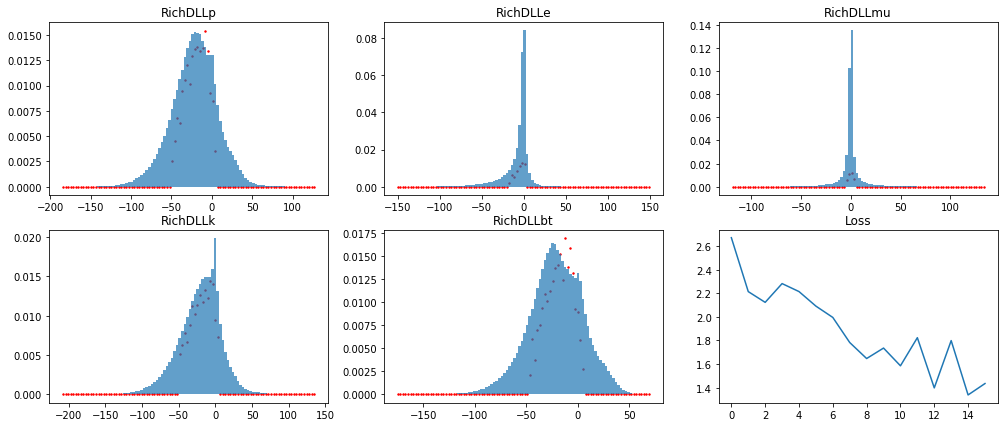

KeyboardInterrupt: 

In [220]:
epoches = 1000
# epoches = 1

for epoch in range(len(metrics), epoches):
    model.train()
    for step, batch_x in enumerate(dataloader):
        batch_x = batch_x[0].to(device)
        optimizer.zero_grad()
        z, logp_z, log_det = model(batch_x)
        logp_x = logp_z + log_det
        loss = -torch.mean(logp_x)
        loss.backward()
        optimizer.step()
    metrics.append(loss.mean().detach())

    if epoch % 1 == 0:
        clear_output(False)
        print(epoch)
        model.eval()
        with torch.no_grad():
            X_test = np.random.uniform(-1, 1, (100000, dim)).astype('float32')
            z, logp_z, log_det = model(torch.from_numpy(X_test).to(device))
            logp_x = logp_z + log_det
            Y_pred = np.exp(logp_x.cpu().numpy())
            X_test = scaler.inverse_transform(X_test)

            fig, axs = plt.subplots(2, 3, figsize=(17, 7))
            for i in range(dim):
                _, bins, _ = axs[i // 3, i % 3].hist(Y_val[:, i], 100, label="data", normed=True, alpha=0.7)
                axs[i // 3, i % 3].scatter(*bin_probs(X_test[:, i], Y_pred, bins), label="generated", c='red', s=2)
                axs[i // 3, i % 3].set_title(dlls[i])
            axs[1, 2].plot(np.arange(len(metrics)), metrics)
            axs[1, 2].set_title('Loss')
        plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


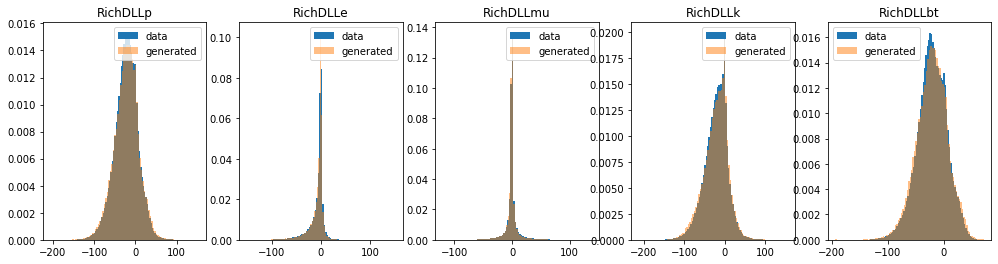

In [210]:
model.eval()
with torch.no_grad():
    Z_test = np.random.normal(0, 1, (100000, dim)).astype('float32')
    x, log_det = model.backward(torch.from_numpy(Z_test).to(device))
    x = x.cpu().numpy()
    x = scaler.inverse_transform(x)
    
    fig, axs = plt.subplots(1, dim, figsize=(17, 4))
    for i in range(dim):
        axs[i].hist(Y_val[:, i], 100, label="data", normed=True)
        axs[i].hist(x[:, i], 100, label="generated", normed=True, alpha=0.5)
        axs[i].legend()
        axs[i].set_title(dlls[i])

In [214]:
d1 = pd.DataFrame(Y_val, columns=dlls)
d2 = pd.DataFrame(x, columns=dlls)
d1.head()

,RichDLLp,RichDLLe,RichDLLmu,RichDLLk,RichDLLbt
0,-28.06310,-9.416380,-2.95021,-32.4217,-27.66200
1,-3.07326,-0.441000,-0.16346,-6.6403,1.36187
2,-21.66340,0.681857,0.30243,-12.9331,-43.00810
3,-79.99410,3.268670,1.53581,-45.8360,-74.19020
4,-30.30510,-30.968500,-6.61420,-30.3051,-30.30510


In [215]:
def f(data, dlls):
    fig, axs = plt.subplots(len(dlls), len(dlls), figsize=(17, 15))#, sharex=True, sharey=True)

    for j, dll1 in enumerate(dlls):
        for i, dll2 in enumerate(dlls):
            q1_1, q1_99 = data[dll1].quantile(0.03), data[dll1].quantile(0.97)
            q2_1, q2_99 = data[dll2].quantile(0.03), data[dll2].quantile(0.97)

            if i == j:
                arr = data[[dll1]].query(f'{q1_1} < {dll1} < {q1_99}')
                axs[i, i].hist(arr[dll1], 100)
                axs[i, i].set_title(dll1)
            else:
                arr = data[[dll1, dll2]] \
                    .query(f'{q1_1} < {dll1} < {q1_99}') \
                    .query(f'{q2_1} < {dll2} < {q2_99}')

                axs[i, j].hist2d(arr[dll1], arr[dll2], (100, 100, ))
                m1, m2 = max(q1_1, q2_1), min(q1_99, q2_99)
                axs[i, j].plot(np.arange(m1, m2, 1), np.arange(m1, m2, 1), c='red')
                axs[i, j].set_title(dll1 + ' ' + dll2)

## Original data distributions

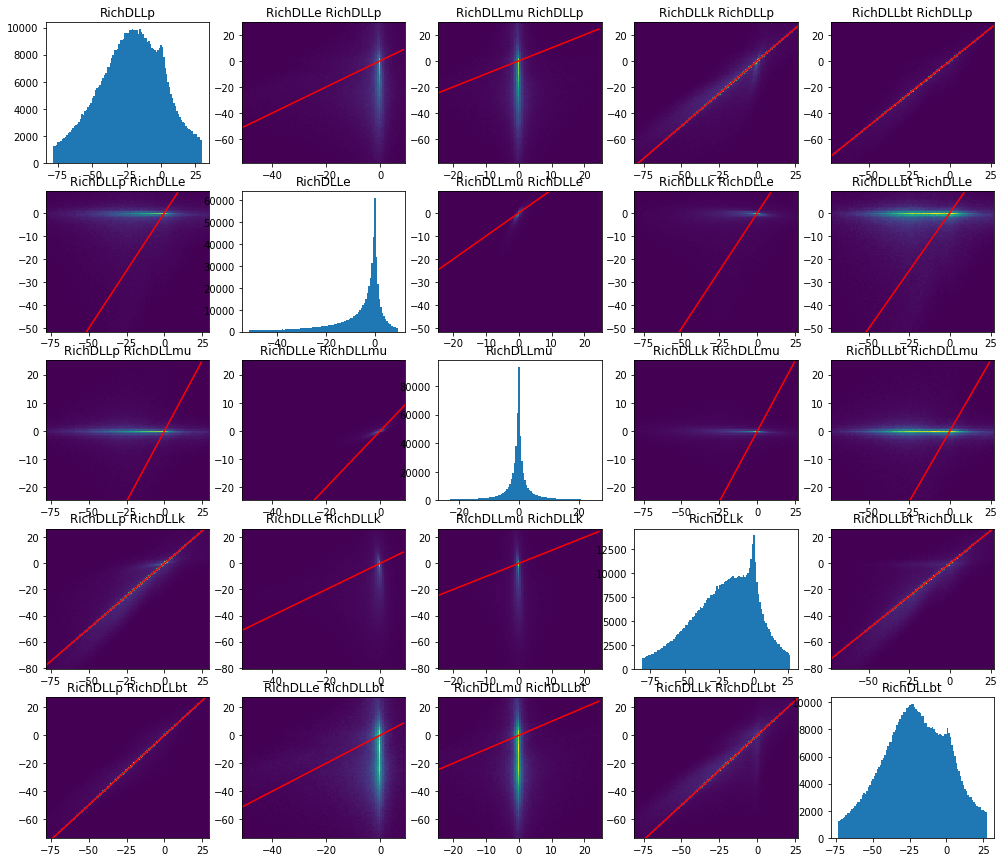

In [216]:
f(d1, dlls)

## Generated data distributions

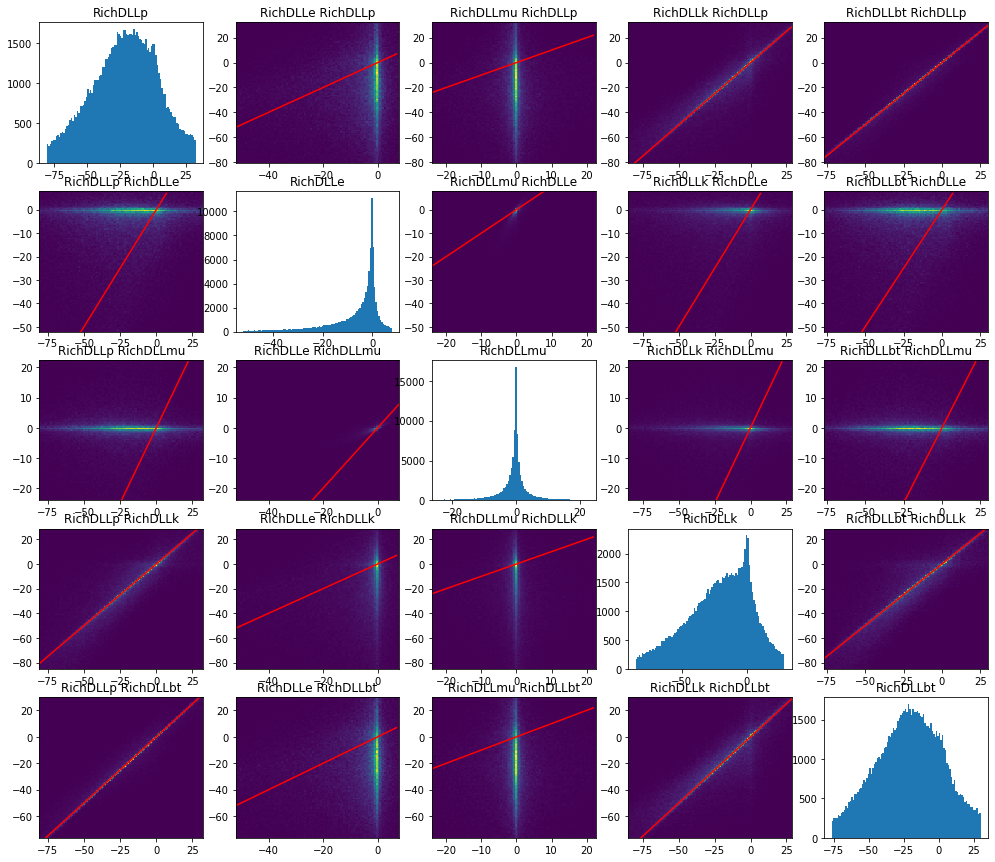

In [217]:
f(d2, dlls)